In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker

In [25]:
act_names = ["ActivityCode", "UserID", "WorkCode", "AssignmentID", "ProductID", "Quantity", "Timestamp", "LocationID"]

act_dtypes = {
    "ActivityCode": str,
    "UserID": int,
    "WorkCode": str,
    "AssignmentID": int,
    "ProductID": float,
    "Quantity": float,
    "Timestamp": str,
    "LocationID": float
}

loc_names = ["LocationID", "Aisle", "Bay", "Level", "Slot"]

loc_dtypes= {
    "LocationID": int,
    "Aisle": str,
    "Bay": str,
    "Level": str,
    "Slot": str
}

prod_names = ["ProductID", "ProductCode", "UnitOfMeasure", "Weight", "Cube", "Length", "Width", "Height"]

prod_dtypes = {
    "ProductID": int,
    "ProductCode": str,
    "UnitOfMeasure": str,
    "Weight": float,
    "Cube": float,
    "Length": float,
    "Width": float,
    "Height": float
}


rt_activity1 = pd.read_csv("../data/database_backups_csv/RT/RT_Activity.csv", header=None, names=act_names, dtype=act_dtypes)
rt_activity2 = pd.read_csv("../data/database_backups_csv/RT/RT_Activity2.csv", header=0, dtype=act_dtypes)
rt_activity = pd.concat([rt_activity1, rt_activity2])
rt_location = pd.read_csv("../data/database_backups_csv/RT/RT_Locations.csv", header=None, names=loc_names, dtype=loc_dtypes)
rt_products = pd.read_csv("../data/database_backups_csv/RT/RT_Products.csv", header=None, names=prod_names, dtype=prod_dtypes)
distance_rt = pd.read_csv("../data/distance_matrices/distance_matrix_RT.csv",
                          index_col="Unnamed: 0")
distance_lookup = distance_rt.stack().reset_index()
distance_lookup.columns = ["Prior_Location", "Location", "Distance"]

In [18]:
oe_activity = pd.read_csv("../data/database_backups_csv/OE/OE_Activity.csv", header=None, names=act_names, dtype=act_dtypes)
of_activity = pd.read_csv("../data/database_backups_csv/OF/OF_Activity.csv", header=None, names=act_names, dtype=act_dtypes)

In [29]:
rt_activity2["Timestamp"].max()

'2026-01-05 21:49:56.000'

In [13]:
rt_products

,ProductID,ProductCode,UnitOfMeasure,Weight,Cube,Length,Width,Height
0,11488,10027,NaN,22.00,NaN,23.00,12.75,15.0
1,11489,10068,NaN,13.68,NaN,15.50,5.50,12.5
2,11490,10076,NaN,21.75,NaN,23.00,12.75,15.0
3,11491,10093,NaN,3360.00,NaN,34.00,40.00,34.0
4,11492,10128,NaN,20.00,NaN,14.25,11.50,8.5
...,...,...,...,...,...,...,...,...
16691,28179,17477,NaN,0.00,0.0,NaN,NaN,NaN
16692,28180,17482,NaN,4.00,0.0,13.00,6.75,4.5
16693,28181,17483,NaN,4.00,0.0,13.00,6.75,4.5
16694,28182,17488,NaN,0.00,0.0,NaN,NaN,NaN


In [ ]:
rt_activity

In [4]:
# Data Cleaning
rt_df = rt_activity.copy()
rt_df = rt_df.merge(rt_location, on="LocationID", how="left")
rt_df = rt_df.merge(rt_products, on="ProductID", how="left")


rt_df["Timestamp"] = pd.to_datetime(rt_df["Timestamp"])
rt_df["Hour"] = rt_df["Timestamp"].dt.hour


rt_df["Aisle"] = rt_df["Aisle"].astype(str).str.replace(r'\.0$', '', regex=True)
single_digits = rt_df["Aisle"].str.match(r'^\d$')
rt_df.loc[single_digits, "Aisle"] = rt_df.loc[single_digits, "Aisle"].str.zfill(2)
rt_df["Aisle"] = rt_df["Aisle"].replace('nan', None)


rt_df["Bay"] = rt_df["Bay"].astype(str).str.replace(r'\.0$', '', regex=True)
single_digits = rt_df["Bay"].str.match(r'^\d$')
rt_df.loc[single_digits, "Bay"] = rt_df.loc[single_digits, "Bay"].str.zfill(2)
rt_df["Bay"] = rt_df["Bay"].replace('nan', None)


rt_df = rt_df.sort_values(["UserID", "Timestamp"])
#rt_df["Hour"] = rt_df["Timestamp"].dt.floor("H")
rt_df["Pick_Time"] = (
    rt_df.groupby("UserID")["Timestamp"]
      .diff()
      .dt.total_seconds() / 3600
)
rt_df["Shift"] = (
    (rt_df["Pick_Time"] >= 3)
    .groupby(rt_df["UserID"])
    .cumsum() + 1
)
rt_df.loc[
    rt_df.groupby(["UserID", "Shift"]).cumcount() == 0,
    "Pick_Time"
] = np.nan
rt_df["Location"] = rt_df["Aisle"] + "|" + rt_df["Bay"] + "|||"


# 1. Ensure sorting is correct first
rt_df = rt_df.sort_values(["UserID", "Timestamp"])
# 2. Identify "Physical" locations (ignore AssignmentOpen)
# We create a temporary column that is Null when it's an AssignmentOpen
rt_df["Temp_Loc"] = rt_df["Location"]
rt_df.loc[rt_df["ActivityCode"] == "AssignmentOpen", "Temp_Loc"] = np.nan
# 3. Find the 'Last Valid Location' within each User/Shift group
# This "jumps over" the AssignmentOpen rows to find the most recent real location
rt_df["Last_Valid_Loc"] = (
    rt_df.groupby(["UserID", "Shift"])["Temp_Loc"]
    .ffill()
)
# 4. Prior_Location is the Last_Valid_Loc rt the PREVIOUS row
rt_df["Prior_Location"] = (
    rt_df.groupby(["UserID", "Shift"])["Last_Valid_Loc"]
    .shift(1)
)
# 5. Perform the Distance Lookup (Merge)
# Ensure your distance_lookup table columns are ["Prior_Location", "Location", "Distance"]
rt_df = rt_df.merge(distance_lookup, on=["Prior_Location", "Location"], how="left")
# 6. Apply Final NULL Rules
# Rule A: No Distance if Pick_Time is NaN (includes the first pick rt a shift)
rt_df.loc[rt_df["Pick_Time"].isna(), "Distance"] = np.nan
# Rule B: No Distance if the current row is AssignmentOpen
rt_df.loc[rt_df["ActivityCode"] == "AssignmentOpen", "Distance"] = np.nan
# 7. Cleanup temporary columns
rt_df.drop(columns=["Temp_Loc", "Last_Valid_Loc", "Distance"], inplace=True)

# Pad WorkCodes for consistency
rt_df["WorkCode"] = rt_df["WorkCode"].str.pad(width=2, side="left", fillchar="0")

In [5]:
distances = distance_lookup.copy()
distances["Prior_Location"] = distances["Prior_Location"].str.replace(":", "|") + "|||"
distances["Location"] = distances["Location"].str.replace(":", "|") + "|||"
joined_df = rt_df.merge(distances, on = ["Prior_Location", "Location"])

/var/folders/73/5rwjffnx27jg1j84mffv_y5m0000gn/T/ipykernel_78068/1143590767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_train["Aisle"] = pick_train["Aisle"].astype("Int64")
/var/folders/73/5rwjffnx27jg1j84mffv_y5m0000gn/T/ipykernel_78068/1143590767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_train["Bay"] = pick_train["Bay"].astype("Int64")


Text(0.5, 1.0, 'Layout of (Item) Pick to Train Tasks (01, 02, 03, 04)')

/opt/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


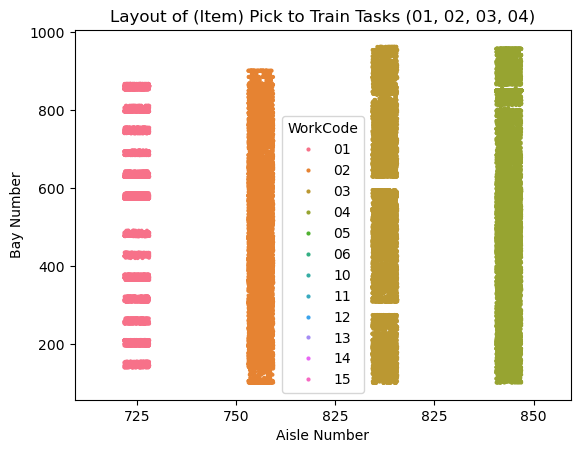

In [175]:
import matplotlib.ticker as ticker

pick_train = rt_df[rt_df["WorkCode"].isin(["01", "02", "03", "04"])]
pick_train["Aisle"] = pick_train["Aisle"].astype("Int64")
pick_train["Bay"] = pick_train["Bay"].astype("Int64")

fig, ax = plt.subplots()
sns.stripplot(data = pick_train, x = "Aisle", y = "Bay", hue = "WorkCode", size = 3, hue_order = ["01", "02", "03", "04", "05", "06", "10", "11", "12", "13", "14", "15"])
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.xlabel("Aisle Number")
plt.ylabel("Bay Number")
plt.title("Layout of (Item) Pick to Train Tasks (01, 02, 03, 04)")

Text(0.5, 1.0, 'Warehouse Layout of RT Colored by WorkCode')

/opt/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


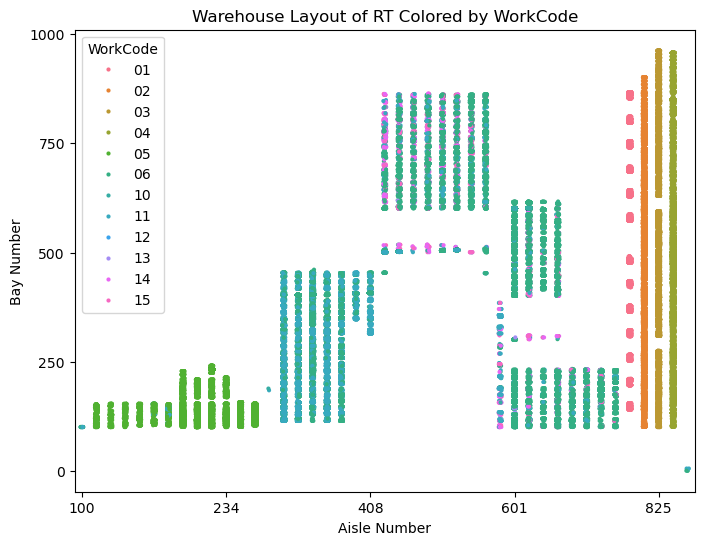

In [7]:
temp_df = rt_df.copy()
temp_df["Aisle"] = temp_df["Aisle"].astype("Int64")
temp_df["Bay"] = temp_df["Bay"].astype("Int64")

fig, ax = plt.subplots(figsize=(8, 6))
sns.stripplot(data = temp_df, x = "Aisle", y = "Bay", hue = "WorkCode", size = 3, hue_order = ["01", "02", "03", "04", "05", "06", "10", "11", "12", "13", "14", "15"])
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.xlabel("Aisle Number")
plt.ylabel("Bay Number")
plt.title("Warehouse Layout of RT Colored by WorkCode")

Text(0.5, 1.0, 'Distance between Consecutive Tasks by WorkCode (Picking)')

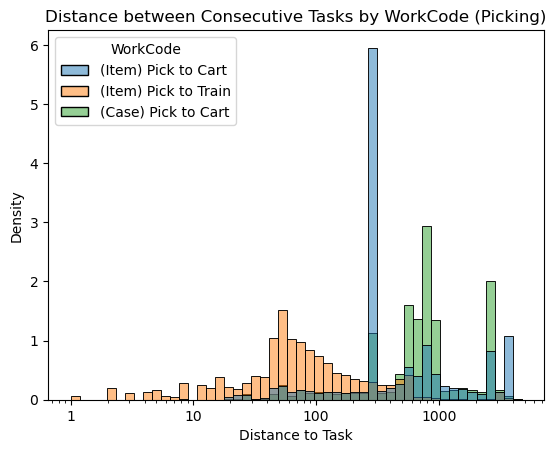

In [ ]:
import matplotlib.ticker as ticker
workcode_dict = {"01": "(Item) Pick to Train",
                 "02": "(Item) Pick to Train",
                 "03": "(Item) Pick to Train",
                 "04": "(Item) Pick to Train",
                 "05": "(Item) Pick to Cart",
                 "06": "(Item) Pick to Cart",
                 "07": "(Item) Pick to Cart",
                 "08": "(Case) Pick to Pallet",
                 "09": "(Case) Pick to Pallet",
                 "10": "(Case) Pick to Cart",
                 "11": "(Case) Pick to Cart",
                 "12": "(Case) Pick to Cart",
                 "13": "(Case) Replenishment",
                 "14": "(Item) Replenishment",
                 "15": "Putaway"}

joined_df = joined_df.replace({"WorkCode": workcode_dict})

close_df = joined_df[joined_df["WorkCode"].isin(["(Item) Pick to Cart", "(Case) Pick to Cart", "(Item) Pick to Train"])]
far_df = joined_df[~(joined_df["WorkCode"].isin(["(Item) Pick to Cart", "(Case) Pick to Cart", "(Item) Pick to Train"]))]

fig, ax = plt.subplots()
ax.set_xscale('log')

sns.histplot(data = close_df, x = "Distance", hue = "WorkCode", common_norm=False, bins=50, stat="density", log_scale=True)

formatter = ticker.ScalarFormatter()
ax.get_xaxis().set_major_formatter(formatter)

plt.xlabel("Distance to Task")
plt.title("Distance between Consecutive Tasks by WorkCode (Picking)")

Text(0.5, 1.0, 'Distance between Consecutive Tasks by WorkCode (Reallocation)')

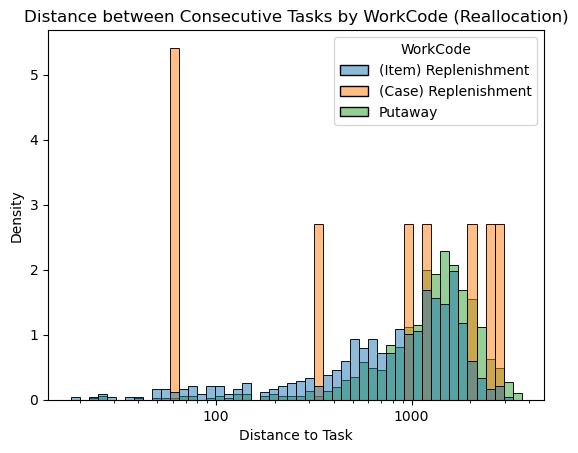

In [172]:
fig, ax = plt.subplots()
ax.set_xscale('log')

sns.histplot(data = far_df, x = "Distance", hue = "WorkCode", common_norm=False, bins=50, stat="density", log_scale=True)

formatter = mticker.ScalarFormatter()
ax.get_xaxis().set_major_formatter(formatter)

plt.xlabel("Distance to Task")
plt.title("Distance between Consecutive Tasks by WorkCode (Reallocation)")

In [ ]:
rt_df["WorkCode"].value_counts()

13998450

Text(0.5, 1.0, '(Item) Replenishment')

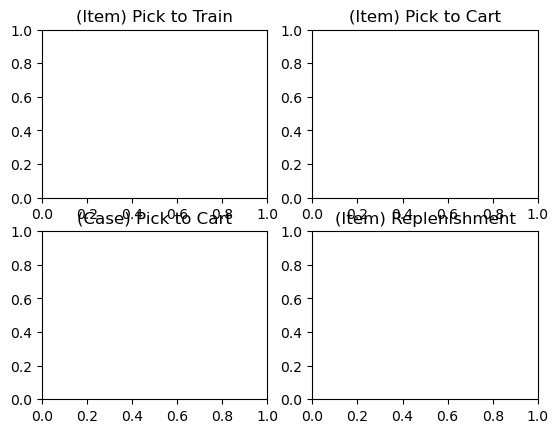

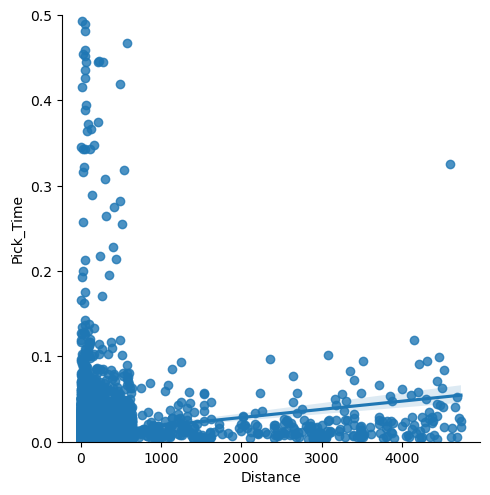

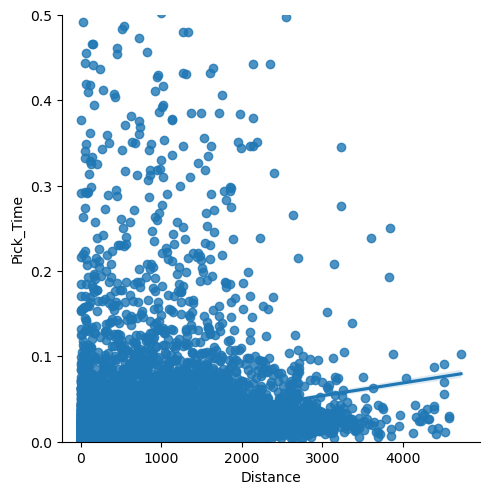

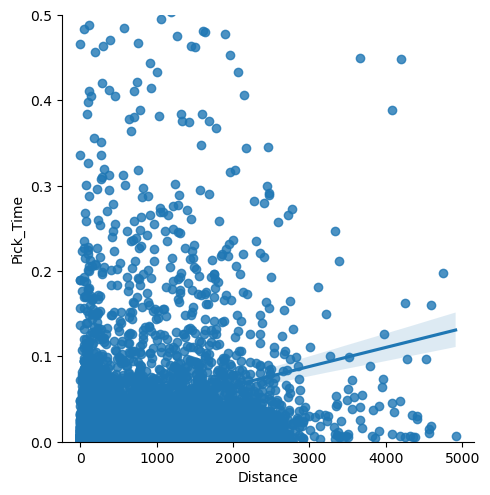

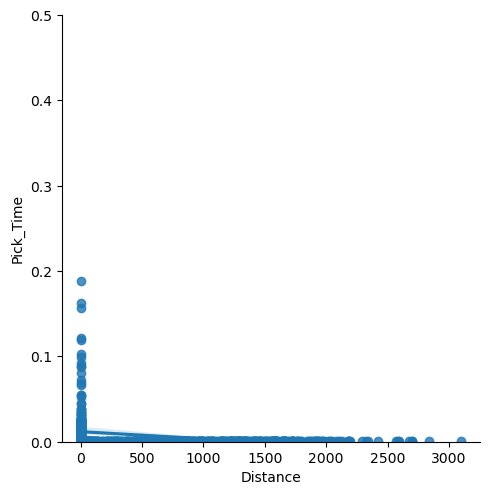

In [104]:
fig, axs = plt.subplots(2, 2)
sns.lmplot(data = joined_df[joined_df["WorkCode"] == "(Item) Pick to Train"], x = "Distance", y = "Pick_Time")
plt.ylim(0, 0.5)
axs[0, 0].set_title("(Item) Pick to Train")
sns.lmplot(data = joined_df[joined_df["WorkCode"] == "(Item) Pick to Cart"], x = "Distance", y = "Pick_Time")
plt.ylim(0, 0.5)
axs[0, 1].set_title("(Item) Pick to Cart")
sns.lmplot(data = joined_df[joined_df["WorkCode"] == "(Case) Pick to Cart"], x = "Distance", y = "Pick_Time")
plt.ylim(0, 0.5)
axs[1, 0].set_title("(Case) Pick to Cart")
sns.lmplot(data = joined_df[joined_df["WorkCode"] == "(Item) Replenishment"], x = "Distance", y = "Pick_Time")
plt.ylim(0, 0.5)
axs[1, 1].set_title("(Item) Replenishment")